# MLP baseline

In this notebook, we use a basic MLP as a baseline for time series predictions, Here, we use the features as the previous 4 hours in the sequence and next time step is the label. We only used the time series data here, we don't include other data like weather or holidays in the training


In [53]:
import numpy as np

In [54]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

fatal: destination path 'ATFM' already exists and is not an empty directory.


In [55]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [56]:
import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data

In [57]:
"""read flow data"""
flow_dir = "./ATFM/data/TaxiNYC/NYC2014.h5"
data = read_h5(flow_dir)
timeslot_data = np.array(data['date'])
flow_data = np.array(data['data'])

flow_data.shape, timeslot_data.shape

((17520, 2, 15, 5), (17520,))

The data is inflow and outflow matrices in NYC

- data shape: (17520, 2, 15, 5)
- number of timeslots: 17520
- grid size: 15x5

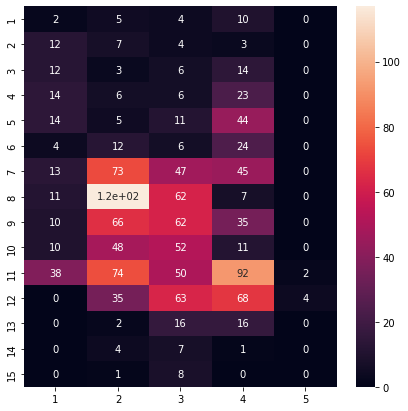

In [58]:
"""Amount of inflow in a certain time slice"""
import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow = flow_data[100, 0, :, :]

x_axis_labels = range(1,6)
y_axis_labels = range(1,16)
plt.figure(figsize=(7,7))
ax = sns.heatmap(one_time_slice_inflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

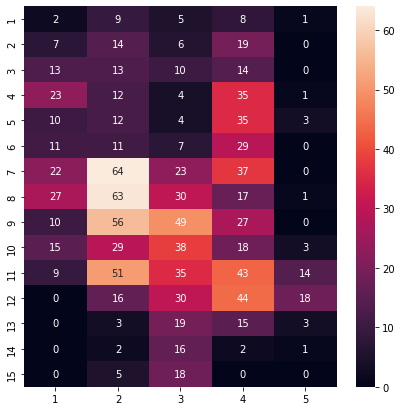

In [59]:
"""Amount of outflow in a certain time slice"""
one_time_slice_outflow = flow_data[100, 1, :, :]

plt.figure(figsize=(7,7))
ax = sns.heatmap(one_time_slice_outflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

In [60]:
"""read weather data"""
meteorology_data_dir = "./ATFM/data/TaxiNYC/Meteorology.h5"
meteorology_data = read_h5(meteorology_data_dir)
print(meteorology_data.keys())
temp_data = np.array(meteorology_data['Temperature'])
weather_data = np.array(meteorology_data['Weather'])
windspeed_data = np.array(meteorology_data['WindSpeed'])
date_data = np.array(meteorology_data['date'])
print(date_data.shape, weather_data.shape, windspeed_data.shape)

dict_keys(['Temperature', 'Weather', 'WindSpeed', 'date'])
(17520,) (17520, 17) (17520,)


In [61]:
"""read holiday data"""
with open('./ATFM/data/TaxiNYC/Holiday.txt', "r") as f:
    holidays = f.readlines()
holidays = np.array([int(h[:-1]) for h in holidays])
holidays

array([20140101, 20140120, 20140217, 20140526, 20140704, 20140901,
       20141013, 20141031, 20141111, 20141127, 20141225])

In [62]:
"""Standardize the data"""
mean = np.mean(flow_data)
std = np.std(flow_data)

flow_data_std = (flow_data-mean)/std

In [63]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def buid_data(data, x_len, y_len):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y

In [78]:
"""Build data and train test split"""
x_len = 4 * 2  # 4 hours X 2 (data recorded each 30minutes)
y_len = 1  # next step
x, y = buid_data(flow_data_std, x_len, y_len)
print(x.shape)
print(y.shape)

xtrain = x[:12279]
ytrain = y[:12279]

xval = x[12279:13479]
yval = y[12279:13479]

xtest = x[13479:]
ytest = y[13479:]

xtrain = xtrain.reshape(xtrain.shape[0], -1)
ytrain = ytrain.reshape(ytrain.shape[0], -1)
xval = xval.reshape(xval.shape[0], -1)
yval = yval.reshape(yval.shape[0], -1)
xtest = xtest.reshape(xtest.shape[0], -1)
ytest = ytest.reshape(ytest.shape[0], -1)
print(xtrain.shape, ytrain.shape)

(17511, 8, 2, 15, 5)
(17511, 1, 2, 15, 5)
(12279, 1200) (12279, 150)


In [80]:
"""MLP baseline"""
import tensorflow as tf

mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=1200),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(150)])
mlp.compile(loss="mse", optimizer="adam")

In [81]:
mlp.fit(
    xtrain,
    ytrain,
    batch_size=10,
    epochs=30,
    validation_data = (xval, yval))

Epoch 1/30
1228/1228 [==============================] - 48s 3ms/step - loss: 0.0540 - val_loss: 0.0298
Epoch 2/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0275 - val_loss: 0.0250
Epoch 3/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0249 - val_loss: 0.0274
Epoch 4/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0237 - val_loss: 0.0209
Epoch 5/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0225 - val_loss: 0.0267
Epoch 6/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0217 - val_loss: 0.0311
Epoch 7/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0207 - val_loss: 0.0229
Epoch 8/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 9/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.0203 - val_loss: 0.0204
Epoch 10/30
1228/1228 [==============================] - 4s 3ms/step - loss: 0.01

In [82]:
"""Recover original values before standardization"""
test_preds = model.predict(xtest)
test_preds = (test_preds*std)+mean
test_true = (ytest*std)+mean

In [84]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(test_true.flatten(), test_preds.flatten())))
print('MAE: ', mean_absolute_error(test_true.flatten(), test_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(test_true.flatten(), test_preds.flatten()), "%")

RMSE:  20.040995131805555
MAE:  10.9773725329442
MAPE:  32.22455240517551 %


In [86]:
test_preds = test_preds.reshape(4032,2, 15, 5)
test_true = test_true.reshape(4032, 2, 15, 5)

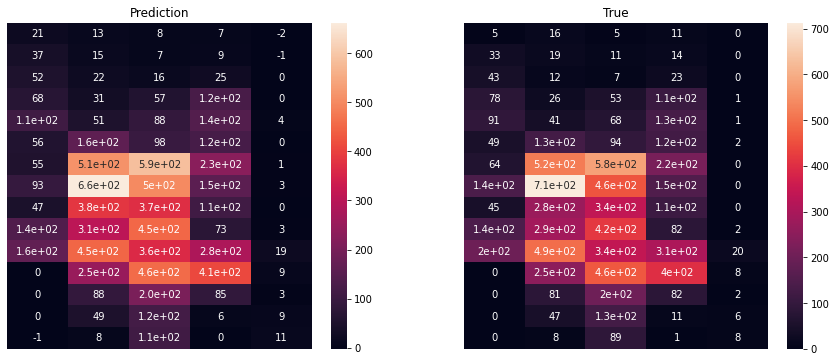

In [87]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = test_true[0, 0, :, :]
one_time_slice_inflow_preds = test_preds[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

x_axis_labels = y_axis_labels = range(16,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

# References:

- https://github.com/jwwthu/DL4Traffic

- https://github.com/liulingbo918/ATFM
